In [7]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
import PTMCMCSampler

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
plt.style.use("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Notes/cross_validation/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery'
Npsrs = 30
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/*-[JB]*.feather'))]
psrn_unsorted = [psr.name for psr in psrs]
psrnames_sorted = np.loadtxt("../misc/psrnames_pbf_sorted.txt", dtype=str)[:Npsrs]
psrs = [psrs[psrn_unsorted.index(psr)] for psr in psrnames_sorted]
print([psr.name for psr in psrs])
Tspan_pta = ds.getspan(psrs)
names = [psr.name for psr in psrs]
n_rn_freqs = 30

['J1909-3744', 'J1918-0642', 'J1832-0836', 'J1614-2230', 'J2010-1323', 'J0645+5158', 'J1853+1303', 'J1600-3053', 'J1738+0333', 'J1910+1256', 'J1640+2224', 'J1730-2304', 'J1944+0907', 'J1741+1351', 'J2214+3000', 'J1923+2515', 'J2229+2643', 'J2145-0750', 'J2322+2057', 'J1024-0719', 'J2017+0603', 'J0740+6620', 'J2033+1734', 'B1953+29', 'J0023+0923', 'J2317+1439', 'J0406+3039', 'J1946+3417', 'J0340+4130', 'J1125+7819']


In [9]:
def makefreespec_crn(components):
    if ds.matrix.jnp == jnp:
        def freespec_crn(f, df, log10_rho, crn_log10_rho):
            phi = jnp.repeat(10.0**(2.0 * log10_rho), 2)
            phi = phi.at[:2*components].add(jnp.repeat(10.0**(2.0 * crn_log10_rho), 2))
            return phi
    elif ds.matrix.jnp == np:
        def freespec_crn(f, df, log10_rho, crn_log10_rho):
            phi = jnp.repeat(10.0**(2.0 * log10_rho), 2)
            phi[:2*components] += jnp.repeat(10.0**(2.0 * crn_log10_rho), 2)
            return phi
    return freespec_crn

m2 = ds.ArrayLikelihood((ds.PulsarLikelihood([psr.residuals,
                                                    ds.makenoise_measurement(psr, psr.noisedict),
                                                    ds.makegp_ecorr(psr, psr.noisedict),
                                                    ds.makegp_timing(psr, svd=True, constant=1e-6)]) for psr in psrs),
                              ds.makecommongp_fourier(psrs, makefreespec_crn(n_rn_freqs), n_rn_freqs, T=Tspan_pta, common=['crn_log10_rho'], name='red_noise'))

In [10]:
model, gl = lncass_models.create_rn_pta_model(psrs, n_rn_freqs)

In [11]:
full_pta_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=7),
    num_warmup=1000,
    num_samples=500,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [12]:
with numpyro.validation_enabled():
    full_pta_sampler.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT, 'sigma_lambda': dist.Uniform(4.999, 5.001), 'mu_lambda': dist.Uniform(-0.001, 0.001)})

sample: 100%|██████████| 1500/1500 [45:34<00:00,  1.82s/it, 127 steps of size 3.44e-03. acc. prob=0.87] 


In [13]:
full_pta_sampler.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
        beta_xi_o[0,0]      0.50      0.75      0.47     -0.61      1.55     14.44      1.04
        beta_xi_o[0,1]      0.53      0.46      0.54     -0.36      1.18      5.01      1.46
        beta_xi_o[0,2]     -0.10      0.82     -0.01     -1.31      1.08      3.84      1.61
        beta_xi_o[0,3]     -0.06      0.73      0.01     -1.33      1.03      9.90      1.16
        beta_xi_o[0,4]     -0.74      0.83     -0.56     -2.24      0.23     13.75      1.00
        beta_xi_o[0,5]     -0.20      0.62     -0.09     -1.35      0.69      8.71      1.28
        beta_xi_o[0,6]     -0.30      0.93     -0.11     -2.04      0.97      5.55      1.12
        beta_xi_o[0,7]      0.58      1.14      0.62     -1.11      2.19      6.98      1.57
        beta_xi_o[0,8]      0.36      0.66      0.50     -0.62      1.48      4.38      1.52
        beta_xi_o[0,9]      0.73      0.83      0.83     -0.59      1

In [14]:
samples = full_pta_sampler.get_samples()

In [15]:
samples['log10_rho'].shape

(500, 30, 31)

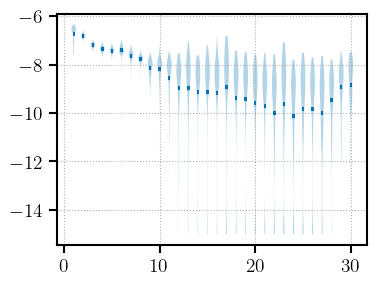

In [16]:
plt.violinplot(samples['log10_rho'][:, :, -1], showmeans=True, showextrema=False)
plt.show()

# Free Spec GW, RN Power law

In [17]:
fspec_gw_model, gl_plrn_fsgw = lncass_models.create_pta_model_plrn_fsgw(psrs, n_rn_freqs)

In [18]:
full_pta_plrn_fsgw = infer.MCMC(
    infer.NUTS(fspec_gw_model, max_tree_depth=7),
    num_warmup=1000,
    num_samples=500,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [19]:
with numpyro.validation_enabled():
    full_pta_plrn_fsgw.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT, 'sigma_lambda': dist.Uniform(4.999, 5.001), 'mu_lambda': dist.Uniform(-0.001, 0.001)})

sample: 100%|██████████| 1500/1500 [35:30<00:00,  1.42s/it, 127 steps of size 3.30e-02. acc. prob=0.94]


In [20]:
samples_plrn_fsgw = full_pta_plrn_fsgw.get_samples()

# PL GW, PL RN

In [21]:
pl_gw_model, gl_pl_gw = lncass_models.create_pta_model_plrn_plgw(psrs, n_rn_freqs)

In [22]:
type(gl_pl_gw)

discovery.likelihood.ArrayLikelihood

In [23]:
full_pta_plrn_plgw = infer.MCMC(
    infer.NUTS(pl_gw_model, max_tree_depth=7),
    num_warmup=1000,
    num_samples=500,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [24]:
with numpyro.validation_enabled():
    full_pta_plrn_plgw.run(jax.random.PRNGKey(23), prior_dict={**PRIOR_DICT, 'sigma_lambda': dist.Uniform(4.999, 5.001), 'mu_lambda': dist.Uniform(-0.001, 0.001)})

sample: 100%|██████████| 1500/1500 [17:47<00:00,  1.40it/s, 63 steps of size 5.66e-02. acc. prob=0.93] 


In [25]:
samples_plrn_plgw = full_pta_plrn_plgw.get_samples()

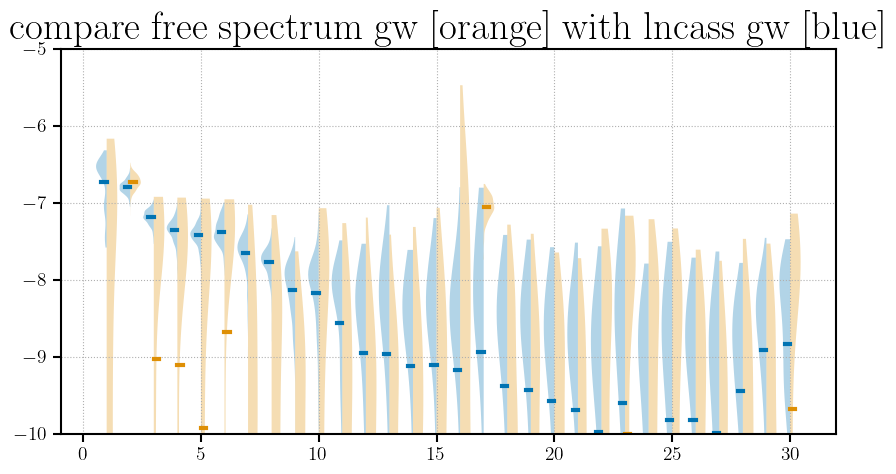

In [26]:
plt.figure(figsize=(10, 5))
plt.title("compare free spectrum gw [orange] with lncass gw [blue]")
plt.violinplot(samples['log10_rho'][:, :, -1], showmeans=True, showextrema=False, side='low', widths=0.9)
plt.violinplot(samples_plrn_fsgw['log10_rho_gw'], showmeans=True, showextrema=False, side='high', widths=0.9)
plt.ylim(-10, -5)
plt.show()

In [31]:
rhos_pl = []
freqs = np.arange(1, n_rn_freqs + 1) / Tspan_pta
fyr = 1 / 86400 / 365.25
for ii in range(500):
    idx = np.random.randint(0, 500)
    log10_A = samples_plrn_plgw['log10_A_rn'][idx, -1]
    gamma = samples_plrn_plgw['log10_gamma_rn'][idx, -1]
    rhos_pl.append(jnp.log10(10**(2*log10_A) / (12 * np.pi**2) * (freqs / fyr)**(-gamma) * fyr**-3 / Tspan_pta) / 2)
    
rhos_pl = np.array(rhos_pl)

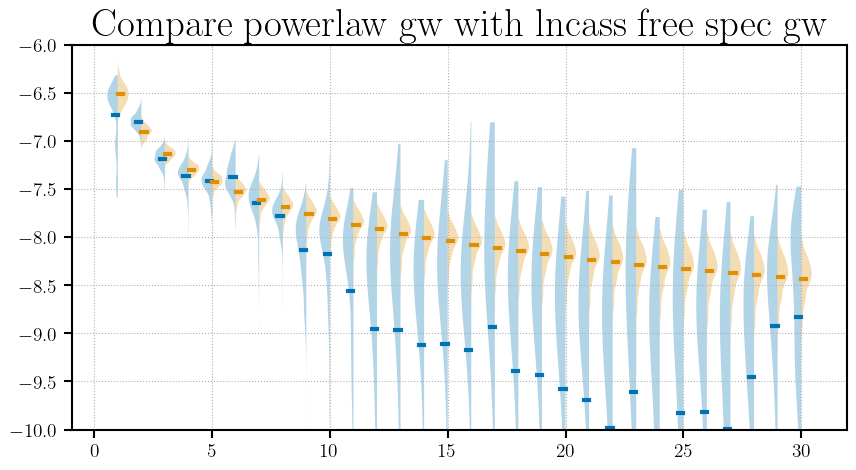

In [32]:

plt.figure(figsize=(10, 5))
plt.title("Compare powerlaw gw with lncass free spec gw")
plt.violinplot(samples['log10_rho'][:, :, -1], showmeans=True, showextrema=False, side='low', widths=0.9)
plt.violinplot(rhos_pl, showmeans=True, showextrema=False, side='high', widths=0.9)
plt.ylim(-10, -6)
plt.show()

# Compare PL red noise with lncass red noise

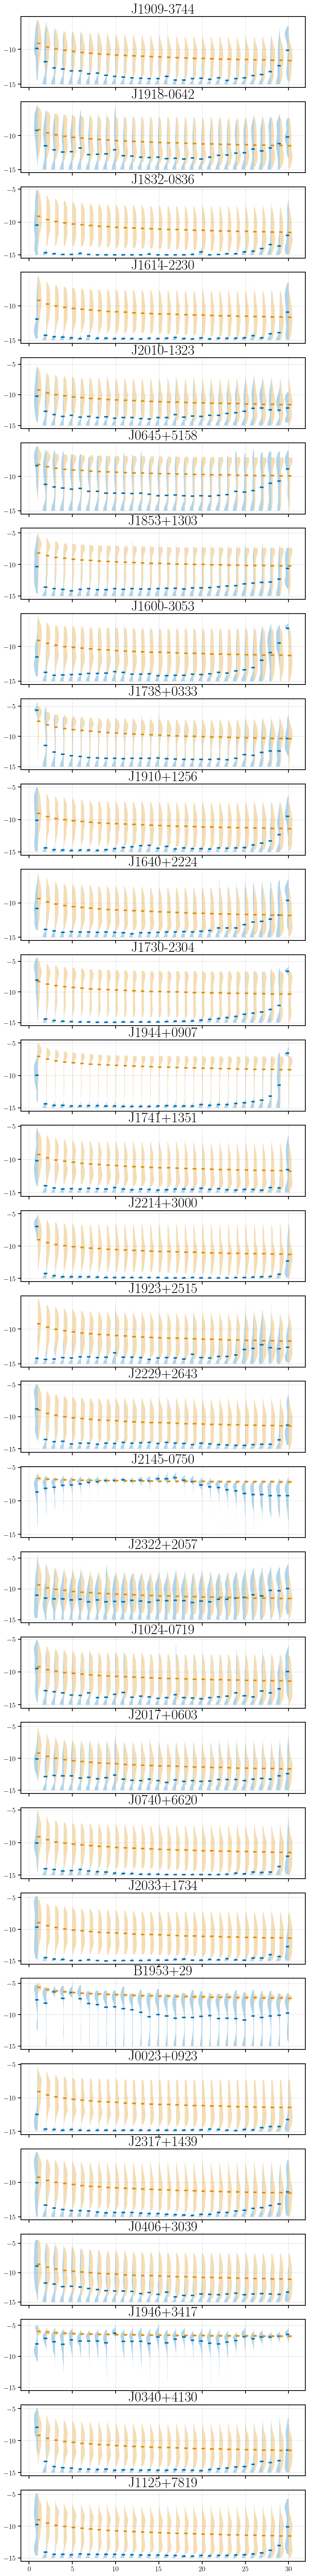

In [29]:
fig, ax = plt.subplots(Npsrs, 1, sharex=True, figsize=(10, 3 * Npsrs))
for ii, psrname in enumerate(psrnames_sorted):
    ax[ii].violinplot(samples['log10_rho'][:, :, ii], showmeans=True, showextrema=False, side='low', widths=0.9)
    ax[ii].set_title(psrname)
    rhos_pl = []
    for kk in range(500):
        idx = np.random.randint(0, 500)
        log10_A = samples_plrn_plgw['log10_A_rn'][idx, ii]
        gamma = samples_plrn_plgw['log10_gamma_rn'][idx, ii]
        rhos_pl.append(jnp.log10(10**(2*log10_A) / (12 * np.pi**2) * (freqs / fyr)**(-gamma) * fyr**-3 / Tspan_pta) / 2)
    ax[ii].violinplot(np.array(rhos_pl), showmeans=True, showextrema=False, side='high', widths=0.9)
plt.show()